# 딥러닝을 활용한 로또 번호 예측
## 0. 라이브러리 설치

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#!pip install tensorflow-gpu==2.0.0-rc1
#!pip install h5py==2.10.0 --force-reinstall
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## 1. 데이터 전처리

In [2]:
rows = np.loadtxt("./lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

983


In [11]:
# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [12]:
numbers = rows[:, 1:7];numbers

array([[10., 23., 29., 33., 37., 40.],
       [ 9., 13., 21., 25., 32., 42.],
       [11., 16., 19., 21., 27., 31.],
       ...,
       [27., 36., 37., 41., 43., 45.],
       [ 5.,  7., 13., 20., 21., 44.],
       [13., 23., 26., 31., 35., 43.]])

In [14]:
ohbins = list(map(numbers2ohbin, numbers))

In [20]:
x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


## 2. 모델 구성 및 학습
* LSTM (RNN계열)
### 2.1. 데이터셋 구성
* Traning: 800
* Validation: 100
* Test: 82

In [21]:
train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print(f"train: {train_idx}, val: {val_idx}, test: {test_idx}")

train: (0, 800), val: (801, 900), test: (901, 982)


### 2.2. 모델 구성 및 학습

In [23]:
# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.021 loss 0.408 val acc 0.051 loss 0.399
epoch    1 train acc 0.028 loss 0.396 val acc 0.051 loss 0.398
epoch    2 train acc 0.029 loss 0.394 val acc 0.051 loss 0.398
epoch    3 train acc 0.034 loss 0.392 val acc 0.040 loss 0.398
epoch    4 train acc 0.036 loss 0.389 val acc 0.030 loss 0.400
epoch    5 train acc 0.025 loss 0.385 val acc 0.051 loss 0.402
epoch    6 train acc 0.036 loss 0.380 val acc 0.040 loss 0.404
epoch    7 train acc 0.036 loss 0.375 val acc 0.030 loss 0.408
epoch    8 train acc 0.035 loss 0.369 val acc 0.020 loss 0.412
epoch    9 train acc 0.036 loss 0.364 val acc 0.020 loss 0.415
epoch   10 train acc 0.043 loss 0.358 val acc 0.030 loss 0.419
epoch   11 train acc 0.050 loss 0.352 val acc 0.010 loss 0.423
epoch   12 train acc 0.058 loss 0.346 val acc 0.010 loss 0.427
epoch   13 train acc 0.064 loss 0.339 val acc 0.010 loss 0.432
epoch   14 train acc 0.068 loss 0.331 val acc 0.010 loss 0.436
epoch   15 train acc 0.079 loss 0.324 val acc 0.010 los

### 2.3. 성능 평가

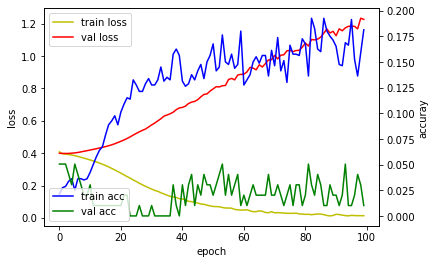

In [25]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

* 딥러닝을 학습시켜도 검증값이 잘 나오지 않음

### 2.4. 예측한 번호를 통하여 상금을 얼마나 받아갈 수 있을까?

In [26]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)

[2432458340.3627234, 57187544.32589286, 1450798.6908482143, 52757.78794642857, 5000.0]


In [27]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [28]:
# 하나의 벡터에서 여러 개의 공을 뽑아 낸다.
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [29]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   5   0   4   1   0   0  12,168,147,654
[   2]   5   0   4   1   0   0  12,168,147,654
[   3]   6   0   4   0   0   0  14,600,553,236
[   4]   3   0   4   2   1   0   7,303,288,731
[   5]   3   0   6   1   0   0   7,306,132,571
[   6]   2   0   6   2   0   0   4,873,726,988
[   7]   2   1   6   1   0   0   4,930,861,774
[   8]   3   0   5   2   0   0   7,304,734,530
[   9]   3   0   6   1   0   0   7,306,132,571
[  10]   3   0   5   1   1   0   7,304,686,772
[  11]   2   0   6   2   0   0   4,873,726,988
[  12]   6   0   4   0   0   0  14,600,553,236
[  13]   3   0   3   3   1   0   7,301,890,690
[  14]   3   0   5   1   1   0   7,304,686,772
[  15]   4   0   4   2   0   0   9,735,742,071
[  16]   3   0   5   1   1   0   7,304,686,772
[  17]   3   0   4   3   0   0   7,303,336,489
[  18]   0   0   5   5   0   0       7,517,782
[  19]   2   0   6   2   0   0   4,873,726,988
[  20]   5   0   5   0   0   0  12,169,545,695
[  21]   4   0   4   

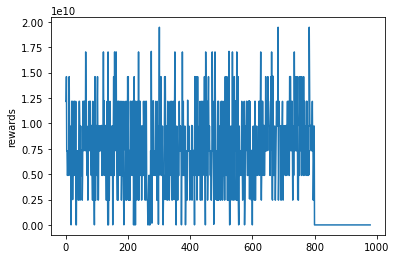

In [30]:
total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

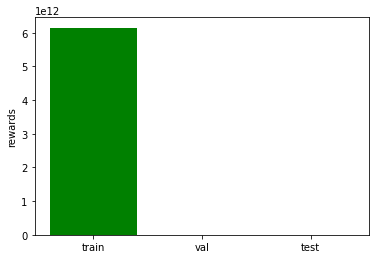

In [31]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

## 3. 실제 예측

In [33]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))

epoch    0 train acc 0.165 loss 0.126
epoch    1 train acc 0.160 loss 0.157
epoch    2 train acc 0.158 loss 0.157
epoch    3 train acc 0.160 loss 0.151
epoch    4 train acc 0.161 loss 0.144
epoch    5 train acc 0.163 loss 0.138
epoch    6 train acc 0.165 loss 0.132
epoch    7 train acc 0.164 loss 0.125
epoch    8 train acc 0.163 loss 0.120
epoch    9 train acc 0.163 loss 0.116
epoch   10 train acc 0.165 loss 0.111
epoch   11 train acc 0.166 loss 0.107
epoch   12 train acc 0.167 loss 0.104
epoch   13 train acc 0.168 loss 0.100
epoch   14 train acc 0.168 loss 0.097
epoch   15 train acc 0.168 loss 0.094
epoch   16 train acc 0.168 loss 0.092
epoch   17 train acc 0.169 loss 0.089
epoch   18 train acc 0.169 loss 0.086
epoch   19 train acc 0.169 loss 0.084
epoch   20 train acc 0.168 loss 0.082
epoch   21 train acc 0.168 loss 0.080
epoch   22 train acc 0.168 loss 0.078
epoch   23 train acc 0.168 loss 0.076
epoch   24 train acc 0.167 loss 0.075
epoch   25 train acc 0.167 loss 0.073
epoch   26 t

In [35]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(5):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n+1, numbers))
    list_numbers.append(numbers)

receive numbers
1 : [1, 16, 29, 33, 35, 42]
2 : [1, 25, 32, 33, 35, 42]
3 : [1, 10, 25, 33, 35, 42]
4 : [1, 2, 17, 25, 33, 35]
5 : [1, 10, 16, 27, 35, 42]
